In [1]:
import os

import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.datasets import make_swiss_roll

from models import *
from utils import *

### Swiss roll dataset

We will start experimenting with a simple distribution, as it is the swiss roll distribution. We will be based on the Sohl Dickstein (https://arxiv.org/abs/1503.03585) and Jonathan Ho (https://arxiv.org/abs/2006.11239) papers

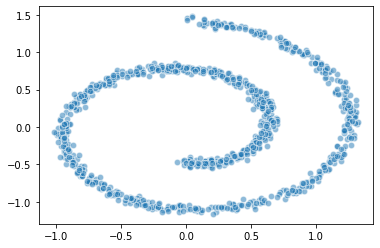

In [2]:
def make_dataset(n_samples=1000, noise=0.3):
    """
    Returns a normalized swiss roll dataset in a (n_samples, 2) matrix, where
    each rows corresponds to a single sample, and each column to a component (x or y).
    """
    points = make_swiss_roll(n_samples=n_samples, noise=noise)[0][:, [0,2]]
    # Normalize the data so it lies between [-1 and 1]
    #max_value = np.max(points)
    max_value = 10.0
    return points/max_value

points = make_dataset(n_samples=1000)
plt.scatter(points[:, 0], points[:, 1], alpha=0.5, color='C0', edgecolor='white', s=40);
plt.show()

### Forward diffusion process

A Gaussian kernel is applied at every step. Given that T is sufficiently large and $\beta$ is considerably small, the final distribution will be a well behaved isotropic gaussian.

$$q(x^{(t)}|x^{(t-1)}) = \mathcal{N}\left(x^{(t)}; \sqrt{1 - \beta_t}x^{(t-1)}, \mathbb{I}\beta_t\right)$$

In the Ho et al. (2021) paper, they use $T=1000$, and the variances are scheduled to increase linearly from $\beta_1 = 10^{-4}$ to $\beta_T = 0.02$.
To obtain $x_t$, we could iteratively apply $q(x_t \mid x_{t-1})$, or we can use the following expression to compute it directly:

$$q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha} _t} x_0, (1 - \bar{\alpha} _t) \mathbb{I})$$

where $\alpha _t = 1 - \beta _t$ and $\bar{\alpha} _t = \prod _{s=1}^t \alpha _s$. It can also be written as:

$$x_t = \sqrt{\bar{\alpha} _t} x_0 + \sqrt{1 - \bar{\alpha} _t}z, \qquad z \sim \mathcal{N}(0, \mathbb{I})$$

In [3]:
T = 100
betas, alphas, alphas_bar = schedule_variances(T=T, mode='sigmoid')
plt.plot(betas, label='betas')
plt.plot(alphas, label='alphas')
plt.plot(alphas_bar, label='alphas_bar')
plt.xlabel("t")
plt.legend()
plt.show()

ValueError: too many values to unpack (expected 3)

As we can see, when increasing $t$, $x_t$ will be closer to a Gaussian distribution of mean 0 and variance 1, as $\bar{ \alpha} _t$ smoothly goes to zero.

In [4]:
rng = default_rng()

points = make_dataset()

betas, alphas, alphas_bar = schedule_variances(T=T, mode='sigmoid')

def forward_q(x_0, t):
    if t <= 0: 
        return x_0
    z = rng.standard_normal(points.shape)
    alpha_bar = alphas_bar[t-1]
    x_t = np.sqrt(alpha_bar)*x_0 + np.sqrt(1 - alpha_bar)*z
    return x_t

fig, axes = plt.subplots(1, 10, figsize=(10*3, 3))
for i, ax in enumerate(axes.flat):
    q_i = forward_q(points, i*10)
    ax.scatter(q_i[:, 0], q_i[:, 1], s=10)
    ax.axis('off'), ax.set_title("t = " + str(10*i))
plt.show()

ValueError: too many values to unpack (expected 3)

### Reverse diffusion process

We have trained a model that predicts que noise for the sample $x_t$ at timestep $t$ (see `train_swissroll.py`). Now, we will use it to perform the reverse process and recover the original distribution.

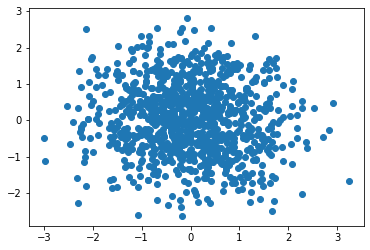

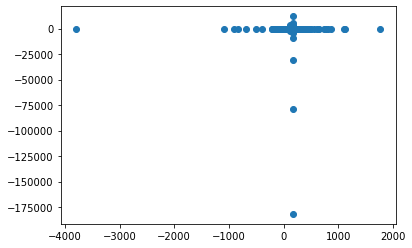

In [6]:
#model = SwissRollModel(input_size=2, T=T)
model = ConditionalModel(T)
model.load_state_dict(torch.load(os.path.join("saved_models", "test.pth")))

T = 100

# Precompute the variance schedule and values derived from it
betas = schedule_variances(T=T, mode='sigmoid')
# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
# Initial distribution
x_t = torch.randn(size=(1000, 2))
plt.plot(x_t[:, 0], x_t[:, 1], color='C0', marker='o', ls='')
plt.show()
for t in range(T-1, -1, -1):
    z = torch.randn(size=x_t.shape) if t >= 0 else torch.zeros(x_t.shape)
    z_pred = model(x_t, torch.tensor(t))
    z_pred = z_pred.detach()
    x_t = (x_t - (1-alphas[t])/(torch.sqrt(1-alphas_cumprod[t])*z_pred))/torch.sqrt(alphas[t]) + torch.sqrt(betas[t])*z
plt.plot(x_t[:, 0], x_t[:, 1], color='C0', marker='o', ls='')
plt.show()